Here we implement histogram gradient boosting classifier tree. 

Parameters below: 
loss='log_loss', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255, categorical_features='warn', monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None, class_weight=None

In [227]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import FeatureHasher
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

First we need to handle the cusomter and vendor IDs because they are categorical data. HistGradBoost Classifer can handle categorical data, but this needs to be encoded beforehand. 

In [248]:
# Read in data from data/new_sm_train
data = pd.read_csv('../data/new_sm_train.csv')

## Below is using encoded customer_id and vendor_id ##
# # Initilize LabelEncoder
# le_vendor = LabelEncoder()

# # Encode vendor_id
# data['vendor_id_encoded'] = le_vendor.fit_transform(data['vendor_id'])

# # Encode customer_id using mean target encoding
# mean_target_per_customer = data.groupby('customer_id')['target'].mean()
# data['customer_id_encoded'] = data['customer_id'].map(round(mean_target_per_customer))

# # Initialize model with categorical features
# categorical_features = ['customer_id_encoded', 'vendor_id_encoded']

# # How categorical features will be included in the model
# # model = HistGradientBoostingClassifier(categorical_features=categorical_features,max_bins=25,max_iter=10)

# # Drop customer_id and vendor_id
# data = data.drop(columns=['customer_id', 'vendor_id', 'latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'])

## Below is removing customer_id and vendor_id ##
data = data.drop(columns=['customer_id', 'vendor_id', 'latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'])
categorical_features = []

print(data.columns)

Index(['vendor_category_id', 'delivery_charge', 'serving_distance',
       'prepration_time', 'discount_percentage', 'vendor_rating', 'target',
       'ordered_before', 'vendor_average', 'customer_average', 'is_favorite',
       'times_ordered', 'is_rated', 'customer_rating', 'distance',
       'distance_scaled', 'ordered_vendor_tag', 'matching_tags_count'],
      dtype='object')


Now that we have encoded the customer and vendor id, we will create a model class to get our evaluation methods.

In [249]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

class ModelEvaluation:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        # Store the model and data
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred = None
        self.y_prob = None
    
    def train(self):
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
    
    def get_predictions(self):
        return self.y_pred

    # Confusion Matrix Visualization
    def get_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Ordered', 'Ordered'], yticklabels=['Not Ordered', 'Ordered'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def get_classification_report(self):
        print(classification_report(self.y_test, self.y_pred))
        
    def get_roc(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.model.predict_proba(self.X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        print(f'ROC AUC: {roc_auc:.3f}')

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    def get_precision_recall(self):
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_prob)
        average_precision = average_precision_score(self.y_test, self.y_prob)
        print(f'Average Precision: {average_precision:.3f}')

        # Plot Precision-Recall curve
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()
        
    def cross_val(self, folds=5):
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=folds, scoring='accuracy')
        print(f'Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')
        
    def get_feature_importance(self):
        feature_names = self.X_test.columns
        result = permutation_importance(self.model, self.X_test, self.y_test, n_repeats=10, random_state=42)

        # Create a DataFrame to display the results
        permutation_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': result.importances_mean,
            'std': result.importances_std
        })

        # Multiply the importances by 100 to convert them to percentages
        permutation_importance_df['importance'] = permutation_importance_df['importance'] * 100
        permutation_importance_df['std'] = permutation_importance_df['std'] * 100

        # Sort the features by importance
        permutation_importance_df = permutation_importance_df.sort_values(by='importance', ascending=False)

        # Print the permutation feature importance
        # for each in permutation_importance_df.iterrows():
        #     print(each)
        # return permutation_importance_df
        plt.figure(figsize=(10, 6))
        plt.barh(permutation_importance_df['feature'], permutation_importance_df['importance'])
        plt.xlabel('Importance (%)')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()  # Reverse the order to have the most important feature on top
        plt.show()
        
            
    def get_accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print(f'Accuracy: {accuracy:.3f}')

Now we will evaluate a few different scenarios:
- Dataset as is w/o class_weight='balanced' in model
- Dataset as is w/ class_weight='balanced' in model
- Undersampling the majority class

In [250]:
##------------Dataset Without Balanced Flag-----------------##
# Prepare X and y
X = data.drop(columns=['target'])
y = data['target']

# Initialize model
model = HistGradientBoostingClassifier(
    categorical_features=categorical_features, 
    max_bins=25, 
    max_iter=10, 
    max_depth=5,
    early_stopping=True,
    n_iter_no_change=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Still stratify y to keep the same distribution

# Create an instance of ModelEvaluation
no_bal_flag_model = ModelEvaluation(model, X_train, X_test, y_train, y_test)
no_bal_flag_model.train()

In [251]:
##------------Dataset With Balanced Flag-----------------##
# Initialize model
model = HistGradientBoostingClassifier(
    categorical_features=categorical_features, 
    class_weight='balanced',
    max_bins=25, 
    max_iter=10, 
    max_depth=5,
    early_stopping=True,
    n_iter_no_change=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Still stratify y to keep the same distribution

# Create an instance of ModelEvaluation
bal_flag_model = ModelEvaluation(model, X_train, X_test, y_train, y_test)
bal_flag_model.train()

In [252]:
##------------Undersampling the Majority-----------------##
# Concatenate X and y for easy manipulation
balanced_data = pd.concat([X, y], axis=1)

# Separate the two classes
class_0 = balanced_data[balanced_data['target'] == 0]
class_1 = balanced_data[balanced_data['target'] == 1]

# Undersample the majority class (0)
class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)

# Combine the minority class and the undersampled majority class
balanced_data_undersampled = pd.concat([class_0_undersampled, class_1])

# Shuffle the dataset
balanced_data_undersampled = balanced_data_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare X and y
X = balanced_data_undersampled.drop(columns=['target'])
y = balanced_data_undersampled['target']

# Initialize model
model = HistGradientBoostingClassifier(
    categorical_features=categorical_features, 
    max_bins=25, 
    max_iter=10, 
    max_depth=5,
    early_stopping=True,
    n_iter_no_change=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Still stratify y to keep the same distribution

# Create an instance of ModelEvaluation
balanced_model = ModelEvaluation(model, X_train, X_test, y_train, y_test)
balanced_model.train()

Now that all models are trained we loop to compare different evaluations.

Evaluation for No Balanced Flag
Accuracy: 0.993
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     84034
           1       1.00      0.59      0.74      1447

    accuracy                           0.99     85481
   macro avg       1.00      0.80      0.87     85481
weighted avg       0.99      0.99      0.99     85481



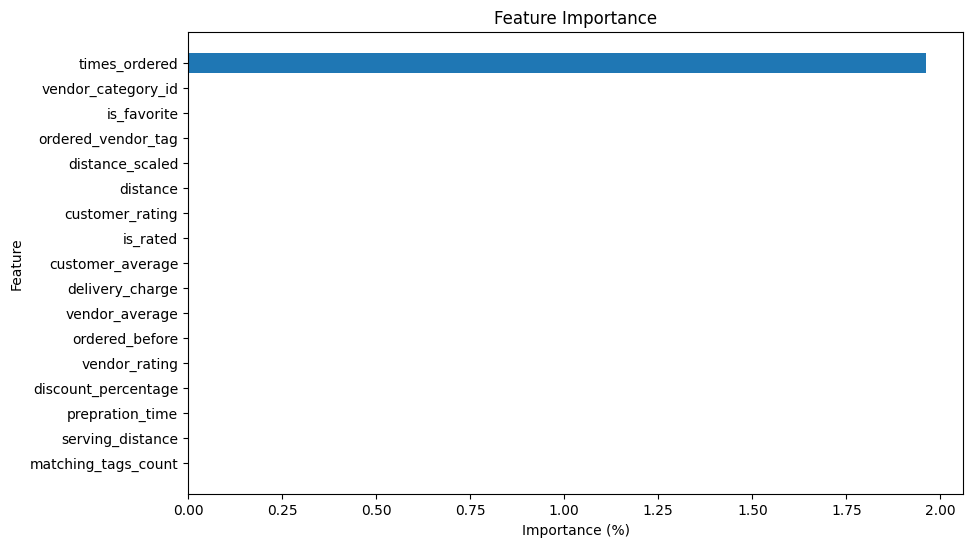

Evaluation for Balanced Flag
Accuracy: 0.922
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     84034
           1       0.15      0.76      0.25      1447

    accuracy                           0.92     85481
   macro avg       0.57      0.84      0.60     85481
weighted avg       0.98      0.92      0.95     85481



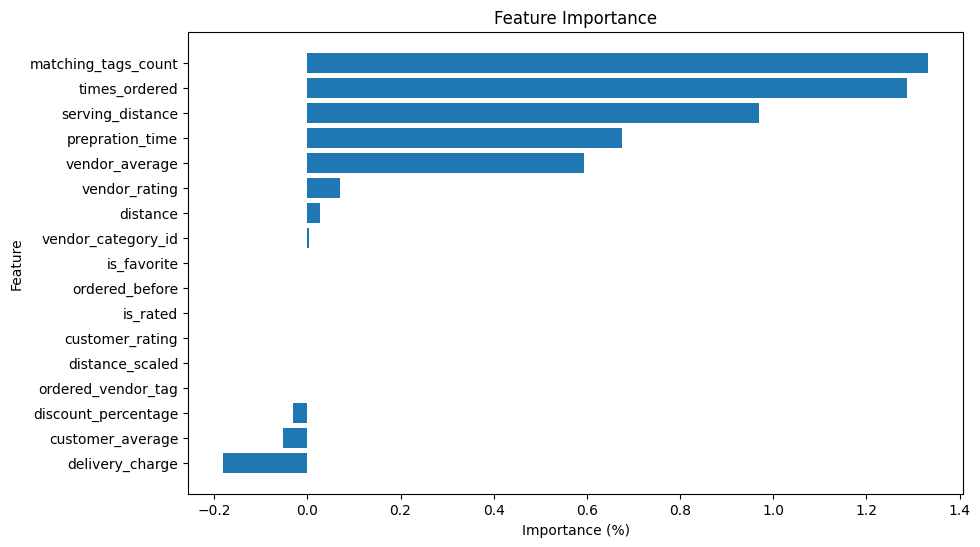

Evaluation for Balanced Data
Accuracy: 0.841
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1448
           1       0.90      0.77      0.83      1447

    accuracy                           0.84      2895
   macro avg       0.85      0.84      0.84      2895
weighted avg       0.85      0.84      0.84      2895



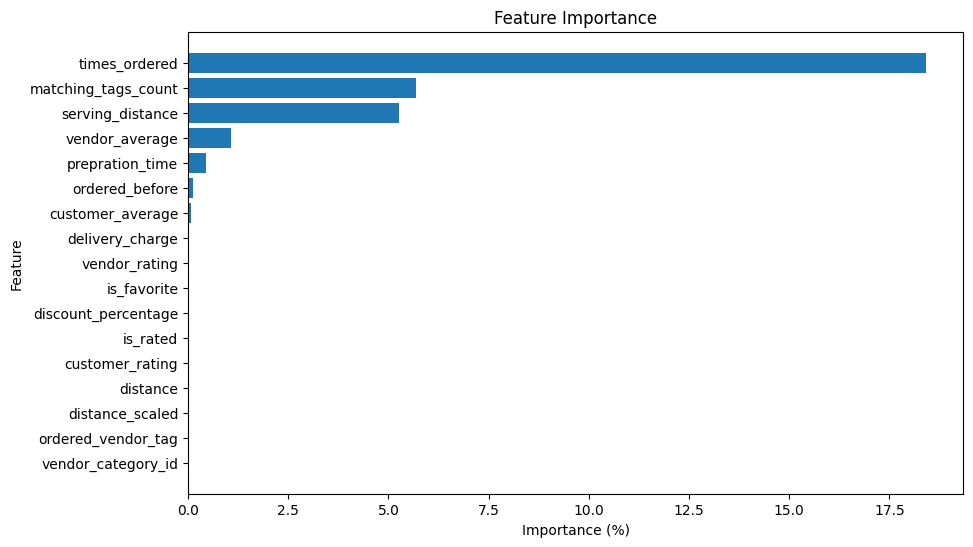

In [ ]:
models = [no_bal_flag_model, bal_flag_model, balanced_model]
model_names = ['No Balanced Flag', 'Balanced Flag', 'Balanced Data']

for model, name in zip(models, model_names):
    print(f'Evaluation for {name}')
    # Uncomment out the following lines to get the evaluation
    model.get_accuracy()
    # model.get_confusion_matrix()
    # model.get_roc()
    model.get_classification_report()
    # model.get_precision_recall()
    model.cross_val()
    # model.get_feature_importance()
    

Because we see the most consistent performance with balanced data, we will go through multiple splits of the majority class to compare how it does overall.

In [254]:
from sklearn.utils import shuffle
import numpy as np

majority_class = data[data['target'] == 0]
minority_class = data[data['target'] == 1]

# Shuffle the majority class
majority_class_shuffled = shuffle(majority_class, random_state=42)

minority_class_size = len(minority_class)

# Calculate number of splits needed to cover the majority class
num_splits = len(majority_class) // minority_class_size

# Initialize lists to store evaluation results
precision_list = []
recall_list = []
f1_list = []

model = HistGradientBoostingClassifier(categorical_features=categorical_features, max_bins=25, max_iter=10, max_depth=5)

# Loop to perform different splits of the majority class
for i in range(num_splits):
    # Select the subset of the majority class for this split
    start_idx = i * minority_class_size
    end_idx = (i + 1) * minority_class_size
    majority_split = majority_class_shuffled.iloc[start_idx:end_idx]
    
    # Combine the majority split with the full minority class
    balanced_data = pd.concat([majority_split, minority_class], axis=0)
    
    # Split into features (X) and target (y)
    X = balanced_data.drop(columns=['target'])
    y = balanced_data['target']
    
    # Split the dataset into train and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Store the classification report for evaluation
    eval_report = classification_report(y_test, y_pred, output_dict=True)
    precision_list.append(eval_report['1']['precision'])
    recall_list.append(eval_report['1']['recall'])
    f1_list.append(eval_report['1']['f1-score'])

# Calculate the average for each metric
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print the averages
print(f"Average Precision for Class 1: {avg_precision:.3f}")
print(f"Average Recall for Class 1: {avg_recall:.3f}")
print(f"Average F1-Score for Class 1: {avg_f1:.3f}")

Average Precision for Class 1: 0.908
Average Recall for Class 1: 0.764
Average F1-Score for Class 1: 0.829
